In [32]:
# import library
import os
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")  
%matplotlib inline

# close copy warning
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_regression, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMClassifier

In [3]:
# define the null value as -1
NULL_VALUE = -1


In [4]:
# read data as dataframe
property_df = pd.read_csv("../data/curated/data.csv")

In [5]:
# list all columns
print(list(property_df.columns))

['address', 'rent_weekly', 'floor', 'suburb', 'postcode', 'type', 'furnitured', 'pool', 'gym', 'num_bed', 'num_bath', 'num_car_park', 'coordinates', 'SECONDARY SCHOOL', 'PRIMARY AND SECONDARY SCHOOL', 'PRIMARY SCHOOL', 'SHOPPING CENTRE', 'PARK', 'KINDERGARTEN', 'POST OFFICE', 'SPECIAL SCHOOL', 'CHILD CARE', 'BAR', 'SPORTS COMPLEX', 'EDUCATION COMPLEX', 'CEMETERY', 'LIBRARY', 'UNIVERSITY', 'GENERAL HOSPITAL', 'POLICE STATION', 'FURTHER EDUCATION', 'PLAYGROUND', 'PLANTATION', 'WINERY', 'FARM', 'VINEYARD', 'TENNIS COURT', 'BAY', 'PIER', 'SWIMMING POOL', 'ART GALLERY', 'HARBOUR', 'COMMUNITY HEALTH CENTRE', 'MARKET', 'PRISON', 'BOTANIC GARDENS', 'SPECIALISED HOSPITAL', 'BANK', 'AGED CARE', 'SURFING SPOT', 'COAST', 'GOLF COURSE', 'HELIPORT', 'AIRPORT', 'IRON ORE PROCESSOR', 'MILL/TIMBER OPERATIONS', 'BEACH', 'TRAIN STATION', 'TRAM STATION', 'BUS', 'Education', 'Commercial', 'Environment', 'Medication', 'Secrity', 'Industrial', 'Prison', 'Transportation', 'cloest_train_station', 'cloest_SECON

In [6]:
def convert_suburb(df):
    '''Convert suburb name to number
    
    Args:
        df: property dataframe
    Return:
        property dataframe with number suburb
    '''
    # all unique suburb name
    suburb_lis = list(df['suburb'].unique())
    
    # convert suburb name to number
    for i in range(1,len(suburb_lis)+1):
        df['suburb'] = df['suburb'].replace(suburb_lis[i-1],i)
    return df

# convert property type to number
property_df['type'] = property_df['type'].replace('Apartment / Unit / Flat / Penhouse', 1)
property_df['type'] = property_df['type'].replace('Studio', 2)
property_df['type'] = property_df['type'].replace('Townhouse','House')
property_df['type'] = property_df['type'].replace('House', 3)
property_df = convert_suburb(property_df)

# delete postcode column
property_df = property_df.drop(columns=['postcode'])

# mark missing value
property_df = property_df.fillna(NULL_VALUE)


In [7]:
property_df

,address,rent_weekly,floor,suburb,type,furnitured,pool,gym,num_bed,num_bath,...,cloest_HELIPORT,cloest_AIRPORT,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance
0,1414/218-228 A'Beckett Street Melbourne VIC 3000,400,14,1,1,0,0,0,1,1,...,4602.243139,10572.425042,58968.064246,63924.811459,4924.342233,122.485883,37.427155,Flagstaff Railway Station (Melbourne City),41.4,282.0
1,11a/131 Lonsdale Sreet Melbourne VIC 3000,350,11,1,2,1,0,0,1,1,...,5564.850055,11141.121440,59761.515319,63682.479322,5709.431207,195.490530,46.128039,Parliament Railway Station (Melbourne City),117.8,762.1
2,911/408 Lonsdale Street Melbourne VIC 3000,330,9,1,1,0,0,0,1,1,...,4821.362032,10953.719391,59069.898510,64077.037494,5011.485174,205.391048,21.831936,Melbourne Central Railway Station (Melbourne C...,69.9,515.3
3,918/422 Collins St Melbourne VIC 3000,600,9,1,1,0,0,0,2,1,...,4669.104831,11385.787890,58748.794039,64563.056533,4705.273027,36.919276,112.474189,Flagstaff Railway Station (Melbourne City),138.9,1103.0
4,602/118 Franklin Street Melbourne VIC 3000,330,6,1,1,0,0,0,1,1,...,4873.599965,10462.311621,59264.949130,63646.805335,5225.088718,168.187210,167.368064,Melbourne Central Railway Station (Melbourne C...,62.6,533.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13450,16B Sandy Mount Avenue Inverloch VIC 3996,550,1,570,3,0,0,0,2,1,...,114739.370455,19432.079609,126198.772047,76148.979868,2434.006157,-1.000000,-1.000000,-1,-1.0,-1.0
13451,28 Beachcomber Drive Inverloch VIC 3996,550,1,570,3,1,0,0,4,2,...,114185.004327,21263.394445,124827.177483,77175.853309,540.604432,-1.000000,-1.000000,-1,-1.0,-1.0
13452,14 Inverloch Parade Inverloch VIC 3996,440,1,570,3,0,0,0,2,1,...,114860.049711,18411.587767,126774.898267,75471.949785,3524.122065,-1.000000,-1.000000,-1,-1.0,-1.0
13453,Inverloch VIC 3996,580,1,570,3,0,0,0,3,2,...,114744.013670,18990.553488,126399.975809,75830.887861,2888.754470,-1.000000,-1.000000,-1,-1.0,-1.0


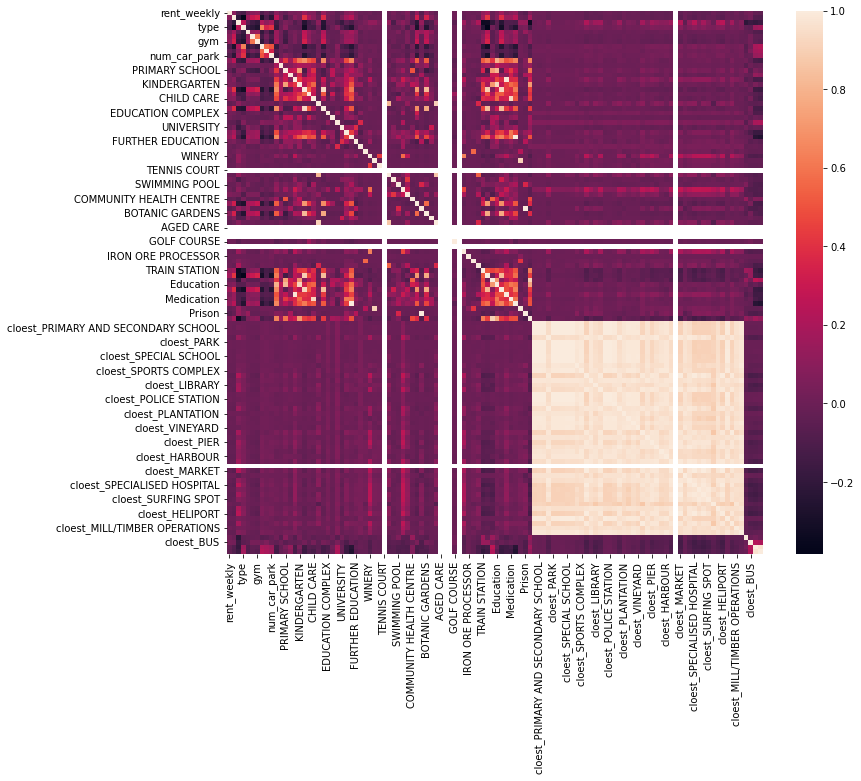

In [8]:
# plot Pearson correlation and save
fig, ax = plt.subplots(figsize = (12,10))
fig = sns.heatmap(property_df.corr())
fig.figure.savefig('../plots/heatmap.png',bbox_inches = 'tight')

In [9]:
# list top 20 correlated features
property_df.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).head(20)

,rent_weekly
rent_weekly,1.000000
TRAM STATION,0.174567
Commercial,0.156781
POST OFFICE,0.147616
SPORTS COMPLEX,0.133844
MARKET,0.123225
type,0.120412
Secrity,0.117222
POLICE STATION,0.117222
TRAIN STATION,0.113993


In [10]:
# split features to internal, external and dimension
internal = property_df[['address', 'rent_weekly', 'floor', 'suburb', 'type', 'furnitured', 'pool', 'gym', 'num_bed', 'num_bath', 'num_car_park']]
external = property_df[['address', 'rent_weekly','SECONDARY SCHOOL', 'PRIMARY AND SECONDARY SCHOOL', 'PRIMARY SCHOOL', 'SHOPPING CENTRE', 'PARK', 'KINDERGARTEN', 'POST OFFICE', 'SPECIAL SCHOOL', 'CHILD CARE', 'BAR', 'SPORTS COMPLEX', 'EDUCATION COMPLEX', 'CEMETERY', 'LIBRARY', 'UNIVERSITY', 'GENERAL HOSPITAL', 'POLICE STATION', 'FURTHER EDUCATION', 'PLAYGROUND', 'PLANTATION', 'WINERY', 'FARM', 'VINEYARD', 'TENNIS COURT', 'BAY', 'PIER', 'SWIMMING POOL', 'ART GALLERY', 'HARBOUR', 'COMMUNITY HEALTH CENTRE', 'MARKET', 'PRISON', 'BOTANIC GARDENS', 'SPECIALISED HOSPITAL', 'BANK', 'AGED CARE', 'SURFING SPOT', 'COAST', 'GOLF COURSE', 'HELIPORT', 'AIRPORT', 'IRON ORE PROCESSOR', 'MILL/TIMBER OPERATIONS', 'BEACH', 'TRAIN STATION', 'TRAM STATION', 'BUS']]
dimension = property_df[['address', 'rent_weekly','Education', 'Commercial', 'Environment', 'Medication', 'Secrity', 'Industrial', 'Prison', 'Transportation']]

In [11]:
# list most correlated internal features
internal.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False)

,rent_weekly
rent_weekly,1.000000
type,0.120412
gym,0.109401
floor,0.101841
num_bed,0.093900
pool,0.091041
suburb,0.087228
num_car_park,0.082851
furnitured,0.036077
num_bath,0.025824


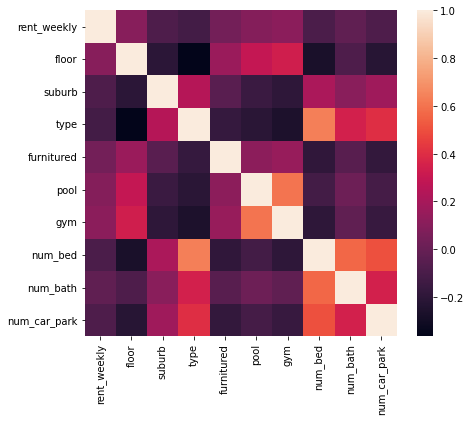

In [12]:
# plot Pearson correlation heatmap and save figure
fig, ax = plt.subplots(figsize = (7,6))
fig = sns.heatmap(internal.corr())
fig.figure.savefig('../plots/heatmap_internal.png',bbox_inches = 'tight')

In [13]:
# internal feature correlations for apartment
internal[internal['type'] == 1].corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False)

,rent_weekly
rent_weekly,1.000000
suburb,0.140465
gym,0.126772
pool,0.102632
floor,0.101654
num_car_park,0.052256
num_bath,0.049523
num_bed,0.041645
furnitured,0.037907
type,NaN


In [14]:
# internal feature correlations for house
internal[internal['type'] == 3].corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False)

,rent_weekly
rent_weekly,1.000000
num_car_park,0.032713
pool,0.023810
suburb,0.023093
num_bed,0.015205
floor,0.008797
gym,0.008449
furnitured,0.003345
num_bath,0.002202
type,NaN


In [15]:
# list top 15 correlated external features
external.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).head(15)

,rent_weekly
rent_weekly,1.000000
TRAM STATION,0.174567
POST OFFICE,0.147616
SPORTS COMPLEX,0.133844
MARKET,0.123225
POLICE STATION,0.117222
TRAIN STATION,0.113993
BOTANIC GARDENS,0.096230
SECONDARY SCHOOL,0.091323
GENERAL HOSPITAL,0.086397


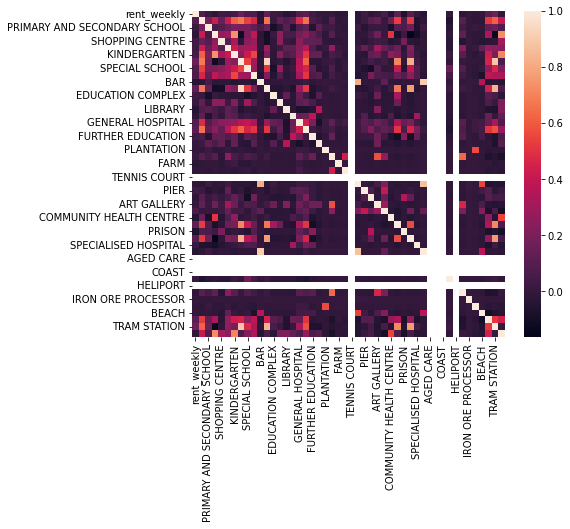

In [16]:
# plot Pearson correlation heatmap and save image
fig, ax = plt.subplots(figsize = (7,6))
fig = sns.heatmap(external.corr())
fig.figure.savefig('../plots/heatmap_external.png',bbox_inches = 'tight')

In [17]:
# list top 15 correlated dimension
dimension.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).head(15)

,rent_weekly
rent_weekly,1.000000
Commercial,0.156781
Secrity,0.117222
Medication,0.083742
Transportation,0.068083
Prison,0.066797
Environment,0.050913
Education,0.049204
Industrial,0.032781


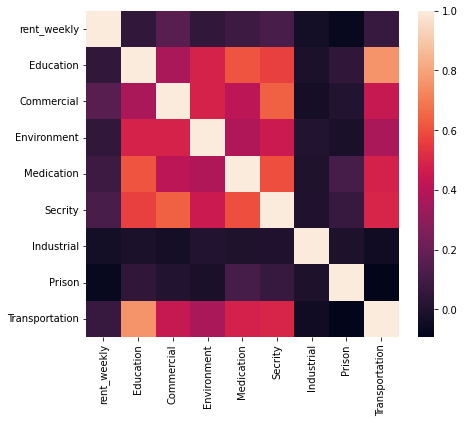

In [18]:
# plot Pearson correlation heatmap and save image
fig, ax = plt.subplots(figsize = (7,6))
fig = sns.heatmap(dimension.corr())
fig.figure.savefig('../plots/heatmap_dimension.png',bbox_inches = 'tight')

In [19]:
# get train data and label
col_lis = ['floor', 'suburb', 'type', 'furnitured', 'pool', 'gym', 'num_bed', 'num_bath', 'num_car_park', 'SECONDARY SCHOOL', 'PRIMARY AND SECONDARY SCHOOL', 'PRIMARY SCHOOL', 'SHOPPING CENTRE', 'PARK', 'KINDERGARTEN', 'POST OFFICE', 'SPECIAL SCHOOL', 'CHILD CARE', 'BAR', 'SPORTS COMPLEX', 'EDUCATION COMPLEX', 'CEMETERY', 'LIBRARY', 'UNIVERSITY', 'GENERAL HOSPITAL', 'POLICE STATION', 'FURTHER EDUCATION', 'PLAYGROUND', 'PLANTATION', 'WINERY', 'FARM', 'VINEYARD', 'TENNIS COURT', 'BAY', 'PIER', 'SWIMMING POOL', 'ART GALLERY', 'HARBOUR', 'COMMUNITY HEALTH CENTRE', 'MARKET', 'PRISON', 'BOTANIC GARDENS', 'SPECIALISED HOSPITAL', 'BANK', 'AGED CARE', 'SURFING SPOT', 'COAST', 'GOLF COURSE', 'HELIPORT', 'AIRPORT', 'IRON ORE PROCESSOR', 'MILL/TIMBER OPERATIONS', 'BEACH', 'TRAIN STATION', 'TRAM STATION', 'BUS', 'Education', 'Commercial', 'Environment', 'Medication', 'Secrity', 'Industrial', 'Transportation', 'cloest_SECONDARY SCHOOL', 'cloest_PRIMARY AND SECONDARY SCHOOL', 'cloest_PRIMARY SCHOOL', 'cloest_SHOPPING CENTRE', 'cloest_PARK', 'cloest_KINDERGARTEN', 'cloest_POST OFFICE', 'cloest_SPECIAL SCHOOL', 'cloest_CHILD CARE', 'cloest_BAR', 'cloest_SPORTS COMPLEX', 'cloest_EDUCATION COMPLEX', 'cloest_CEMETERY', 'cloest_LIBRARY', 'cloest_UNIVERSITY', 'cloest_GENERAL HOSPITAL', 'cloest_POLICE STATION', 'cloest_FURTHER EDUCATION', 'cloest_PLAYGROUND', 'cloest_PLANTATION', 'cloest_WINERY', 'cloest_FARM', 'cloest_VINEYARD', 'cloest_TENNIS COURT', 'cloest_BAY', 'cloest_PIER', 'cloest_SWIMMING POOL', 'cloest_ART GALLERY', 'cloest_HARBOUR', 'cloest_COMMUNITY HEALTH CENTRE', 'cloest_MATERNAL AND CHILD HEALTH CENTRE', 'cloest_MARKET', 'cloest_PRISON', 'cloest_BOTANIC GARDENS', 'cloest_SPECIALISED HOSPITAL', 'cloest_BANK', 'cloest_AGED CARE', 'cloest_SURFING SPOT', 'cloest_COAST', 'cloest_GOLF COURSE', 'cloest_HELIPORT', 'cloest_AIRPORT', 'cloest_IRON ORE PROCESSOR', 'cloest_MILL/TIMBER OPERATIONS', 'cloest_BEACH', 'cloest_TRAM STATION', 'cloest_BUS', 'cloest_TRAIN_STATION_duration', 'cloest_TRAIN_STATION_distance']

# split dataset and standardization train data
X = property_df[col_lis].copy()
y = property_df['rent_weekly']
X_norm = MinMaxScaler().fit_transform(X)

## Mutual Information

In [20]:
# select top 15 features
mi_selector = SelectKBest(mutual_info_classif, k=15)

# train model and calculate MI score
mi_selector.fit(X, y)
mi_scores = mi_selector.scores_

# if the feature is top 15, then support is True
mi_support = mi_selector.get_support()

# extract top 15 feature name and index
mi_feature = X.loc[:,mi_support].columns.tolist()
idx = [x for x in range(len(mi_support)) if mi_support[x]]

# show it as dataframe
score = {}
for i in idx:
    score[col_lis[i]] = mi_scores[i]
pd.DataFrame.from_dict({'features':score.keys(), 'mi_value':score.values()}).sort_values(by=['mi_value'], ascending=False)

,features,mi_value
0,suburb,0.183869
9,cloest_BANK,0.102806
12,cloest_COAST,0.095809
11,cloest_SURFING SPOT,0.088402
10,cloest_AGED CARE,0.084975
7,cloest_PRISON,0.083927
2,Transportation,0.081860
8,cloest_SPECIALISED HOSPITAL,0.080291
4,cloest_TENNIS COURT,0.073593
1,BUS,0.073282


## Chi-Squared

In [21]:
# select top 15 features
chi_selector = SelectKBest(chi2, k=15)

# train model and calculate Chi2 score, p value
chi_selector.fit(X_norm, y)
chi_scores = chi_selector.scores_
chi_pvalues = chi_selector.pvalues_

# if the feature is top 15, then support is True
chi_support = chi_selector.get_support()

# extract top 15 feature name and index
chi_feature = X.loc[:,chi_support].columns.tolist()
idx = [x for x in range(len(chi_support)) if chi_support[x]]

# show it as dataframe
score = {}
for i in idx:
    score[col_lis[i]] = chi_scores[i]
print(score)
pvalue = {}
for i in idx:
    pvalue[col_lis[i]] = chi_pvalues[i]
print(pvalue)
pd.DataFrame.from_dict({'features':score.keys(), 'chi2_value':score.values()}).sort_values(by=['chi2_value'], ascending=False)

{'furnitured': 337.87520193832256, 'pool': 411.683649396211, 'gym': 470.6203685340238, 'POST OFFICE': 278.50359442529583, 'BAR': 323.1257806418002, 'SPORTS COMPLEX': 370.9612416196758, 'UNIVERSITY': 245.15242936719983, 'MARKET': 440.6735061157669, 'PRISON': 280.8483981454798, 'BOTANIC GARDENS': 377.9231475204045, 'SPECIALISED HOSPITAL': 270.04275121613745, 'BANK': 423.93905745138017, 'AIRPORT': 265.9485149357361, 'TRAM STATION': 361.7166805637459, 'Commercial': 267.8671762048476}
{'furnitured': 6.5274812019246514e-09, 'pool': 1.8730038623850685e-16, 'gym': 1.7304404709667688e-23, 'POST OFFICE': 0.000288383414893084, 'BAR': 1.278831760349823e-07, 'SPORTS COMPLEX': 4.3394908837676094e-12, 'UNIVERSITY': 0.020512837298848535, 'MARKET': 8.080540767763871e-20, 'PRISON': 0.00020275639302502416, 'BOTANIC GARDENS': 8.401018788117538e-13, 'SPECIALISED HOSPITAL': 0.0009734716735017774, 'BANK': 7.481273516333391e-18, 'AIRPORT': 0.0016993160747771228, 'TRAM STATION': 3.642666242704972e-11, 'Commerc

,features,chi2_value
2,gym,470.620369
7,MARKET,440.673506
11,BANK,423.939057
1,pool,411.683649
9,BOTANIC GARDENS,377.923148
5,SPORTS COMPLEX,370.961242
13,TRAM STATION,361.716681
0,furnitured,337.875202
4,BAR,323.125781
8,PRISON,280.848398


## Pearson Correlation

In [35]:
def cor_selector(X, y,num_feats):
    '''Calculate pearson correlation
    
    Args:
        X:
        y:
        num_feats:
    Return:
        most matchable suburb name
    '''
    cor_list = []
    feature_name = X.columns.tolist()

    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    # replace missing value with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    
    # get the feature name and select feature
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [36]:
# select top 15 features
cor_support, cor_feature = cor_selector(X, y,15)
print(str(len(cor_feature)), 'selected features')

15 selected features


## Recursive Feature Elimination

In [23]:
# select top 15 features
rfe_selector = RFE(estimator=LogisticRegression(max_iter=10000), n_features_to_select=15, step=10, verbose=5)

# train model
rfe_selector.fit(X_norm, y)

# extract top 15 feature name
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
rfe_feature

Fitting estimator with 112 features.
Fitting estimator with 102 features.
Fitting estimator with 92 features.
Fitting estimator with 82 features.
Fitting estimator with 72 features.
Fitting estimator with 62 features.
Fitting estimator with 52 features.
Fitting estimator with 42 features.
Fitting estimator with 32 features.
Fitting estimator with 22 features.


['furnitured',
 'pool',
 'num_car_park',
 'SECONDARY SCHOOL',
 'SHOPPING CENTRE',
 'SPECIAL SCHOOL',
 'UNIVERSITY',
 'COMMUNITY HEALTH CENTRE',
 'PRISON',
 'TRAIN STATION',
 'TRAM STATION',
 'Secrity',
 'cloest_TRAM STATION',
 'cloest_BUS',
 'cloest_TRAIN_STATION_duration']

## Embedded Method: Lasso regression

In [24]:
# select top 15 features
embeded_lr_selector = SelectFromModel(LogisticRegression(solver='liblinear',penalty="l1",max_iter=10000), max_features=15)

# train model
embeded_lr_selector.fit(X_norm, y)

# extract top 15 feature name
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
embeded_lr_feature

['suburb',
 'type',
 'furnitured',
 'pool',
 'SECONDARY SCHOOL',
 'SHOPPING CENTRE',
 'SPECIAL SCHOOL',
 'CEMETERY',
 'UNIVERSITY',
 'FURTHER EDUCATION',
 'COMMUNITY HEALTH CENTRE',
 'PRISON',
 'TRAIN STATION',
 'Secrity',
 'cloest_TRAM STATION']

## Embedded Method: Tree-based RandomForest

In [25]:
# select top 15 features
embeded_rf_selector = SelectFromModel(RandomForestRegressor(n_estimators = 1000, max_features = 'sqrt', max_depth = 50, random_state = 50), max_features=15)

# train model
embeded_rf_selector.fit(X, y)

# extract top 15 feature name
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
embeded_rf_feature


['floor',
 'cloest_SECONDARY SCHOOL',
 'cloest_PRIMARY SCHOOL',
 'cloest_SHOPPING CENTRE',
 'cloest_PARK',
 'cloest_KINDERGARTEN',
 'cloest_CHILD CARE',
 'cloest_BAY',
 'cloest_HARBOUR',
 'cloest_PRISON',
 'cloest_BANK',
 'cloest_AGED CARE',
 'cloest_SURFING SPOT',
 'cloest_BEACH',
 'cloest_BUS']

## Lightgbm

In [26]:
# model initialization
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

# select top 15 features
embeded_lgb_selector = SelectFromModel(lgbc, max_features=15)

# train model
embeded_lgb_selector.fit(X, y)
embeded_lgb_support = embeded_lgb_selector.get_support()

# extract top 15 feature name
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
embeded_lgb_feature

['cloest_SECONDARY SCHOOL',
 'cloest_PRIMARY SCHOOL',
 'cloest_PARK',
 'cloest_KINDERGARTEN',
 'cloest_POST OFFICE',
 'cloest_CHILD CARE',
 'cloest_SPORTS COMPLEX',
 'cloest_UNIVERSITY',
 'cloest_GENERAL HOSPITAL',
 'cloest_POLICE STATION',
 'cloest_PLAYGROUND',
 'cloest_VINEYARD',
 'cloest_SWIMMING POOL',
 'cloest_BUS',
 'cloest_TRAIN_STATION_distance']

## Embedded Method: Tree-based Extra Trees

In [27]:
# select top 15 features
extra_tree = ExtraTreesClassifier()
extra_tree_selector = SelectFromModel(extra_tree, max_features=15)

# select top 15 features
extra_tree_selector.fit(X,y)
extra_tree_support = extra_tree_selector.get_support()

# extract top 15 feature name
extra_tree_feature = X.loc[:, extra_tree_support].columns.tolist()
extra_tree_feature

['floor',
 'num_bed',
 'num_bath',
 'num_car_park',
 'cloest_SECONDARY SCHOOL',
 'cloest_PRIMARY AND SECONDARY SCHOOL',
 'cloest_PRIMARY SCHOOL',
 'cloest_PARK',
 'cloest_KINDERGARTEN',
 'cloest_POST OFFICE',
 'cloest_SPECIAL SCHOOL',
 'cloest_CHILD CARE',
 'cloest_SPORTS COMPLEX',
 'cloest_GENERAL HOSPITAL',
 'cloest_POLICE STATION']

## Embedded Method: Tree-based DecisionTree

In [28]:
# select top 15 features
dt = DecisionTreeRegressor(max_depth=100)
dt_selector = SelectFromModel(dt, max_features=15)

# select top 15 features
dt_selector.fit(X,y)
dt_support = dt_selector.get_support()

# extract top 15 feature name
dt_feature = X.loc[:, dt_support].columns.tolist()
dt_feature

['floor',
 'suburb',
 'cloest_SECONDARY SCHOOL',
 'cloest_PRIMARY SCHOOL',
 'cloest_SHOPPING CENTRE',
 'cloest_PARK',
 'cloest_KINDERGARTEN',
 'cloest_POST OFFICE',
 'cloest_CHILD CARE',
 'cloest_SPORTS COMPLEX',
 'cloest_FARM',
 'cloest_HARBOUR',
 'cloest_BANK',
 'cloest_BUS',
 'cloest_TRAIN_STATION_distance']

## Count the frequency 

In [34]:
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':X.columns.to_list(), 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support, 'MI':mi_support,
                                    'Extra Tree': extra_tree_support, 'DT': dt_support})

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)


In [30]:
# show the top 60 features
feature_selection_df.head(60)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,MI,Extra Tree,DT,Total
1,pool,True,True,True,True,False,False,False,False,False,4
2,floor,True,False,False,False,True,False,False,True,True,4
3,cloest_SECONDARY SCHOOL,False,False,False,False,True,True,False,True,True,4
4,cloest_PRIMARY SCHOOL,False,False,False,False,True,True,False,True,True,4
5,cloest_PARK,False,False,False,False,True,True,False,True,True,4
6,cloest_KINDERGARTEN,False,False,False,False,True,True,False,True,True,4
7,cloest_CHILD CARE,False,False,False,False,True,True,False,True,True,4
8,cloest_BUS,False,False,True,False,True,True,False,False,True,4
9,suburb,False,False,False,True,False,False,True,False,True,3
10,furnitured,False,True,True,True,False,False,False,False,False,3


In [31]:
# save the feature select result
feature_selection_df.to_csv('../data/curated/feature_selection.csv', index = False)